<a href="https://colab.research.google.com/github/imabari/covid19-data/blob/master/ibaraki/ibaraki_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!add-apt-repository ppa:alex-p/tesseract-ocr -y
!apt update
!apt install tesseract-ocr
!apt install libtesseract-dev
!tesseract -v

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://ppa.launchpad.net/alex-p/tesseract-ocr/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu b

In [30]:
!apt install tesseract-ocr-jpn  tesseract-ocr-jpn-vert
!apt install tesseract-ocr-script-jpan tesseract-ocr-script-jpan-vert
!tesseract --list-langs
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr-jpn is already the newest version (1:4.0.0+git39-6572757-1ppa1~bionic1).
tesseract-ocr-jpn-vert is already the newest version (1:4.0.0+git39-6572757-1ppa1~bionic1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr-script-jpan is already the newest version (1:4.0.0+git39-6572757-1ppa1~bionic1).
tesseract-ocr-script-jpan-vert is already the newest version (1:4.0.0+git39-6572757-1ppa1~bionic1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
List of available languages (6):
Japanese
Japanese_vert
eng
jpn
jpn_vert
osd


In [31]:
import requests
from bs4 import BeautifulSoup

In [32]:
from urllib.parse import urljoin

In [33]:
import pathlib
import re

In [34]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; rv:11.0) like Gecko"
}

In [35]:
def fetch_soup(url, parser="html.parser"):

    r = requests.get(url, headers=headers)
    r.raise_for_status()

    soup = BeautifulSoup(r.content, parser)

    return soup

In [36]:
def fetch_file(url, dir="."):

    p = pathlib.Path(dir, pathlib.PurePath(url).name)
    p.parent.mkdir(parents=True, exist_ok=True)

    r = requests.get(url)
    r.raise_for_status()

    with p.open(mode="wb") as fw:
        fw.write(r.content)
    return p

In [37]:
url = "https://www.pref.ibaraki.jp/1saigai/2019-ncov/index.html"

In [38]:
soup = fetch_soup(url)

In [39]:
# 累計感染者数
data = [int(soup.select_one("strong > a").get_text(strip=True).rstrip("名").replace(",", ""))]

In [40]:
src = (
    soup.find("h2", text="茨城県内の新型コロナウイルス感染症の陽性者の状況")
    .find_next_sibling("p")
    .find("img", alt=re.compile("の陽性者の状況$"))
    .get("src")
)

In [41]:
link = urljoin(url, src)

In [42]:
p_img = fetch_file(link)

In [43]:
try:
    from PIL import Image
except ImportError:
    import Image
    
import pytesseract

In [44]:
import cv2
import numpy as np

In [45]:
from google.colab.patches import cv2_imshow

In [46]:
src = cv2.imread(str(p_img))

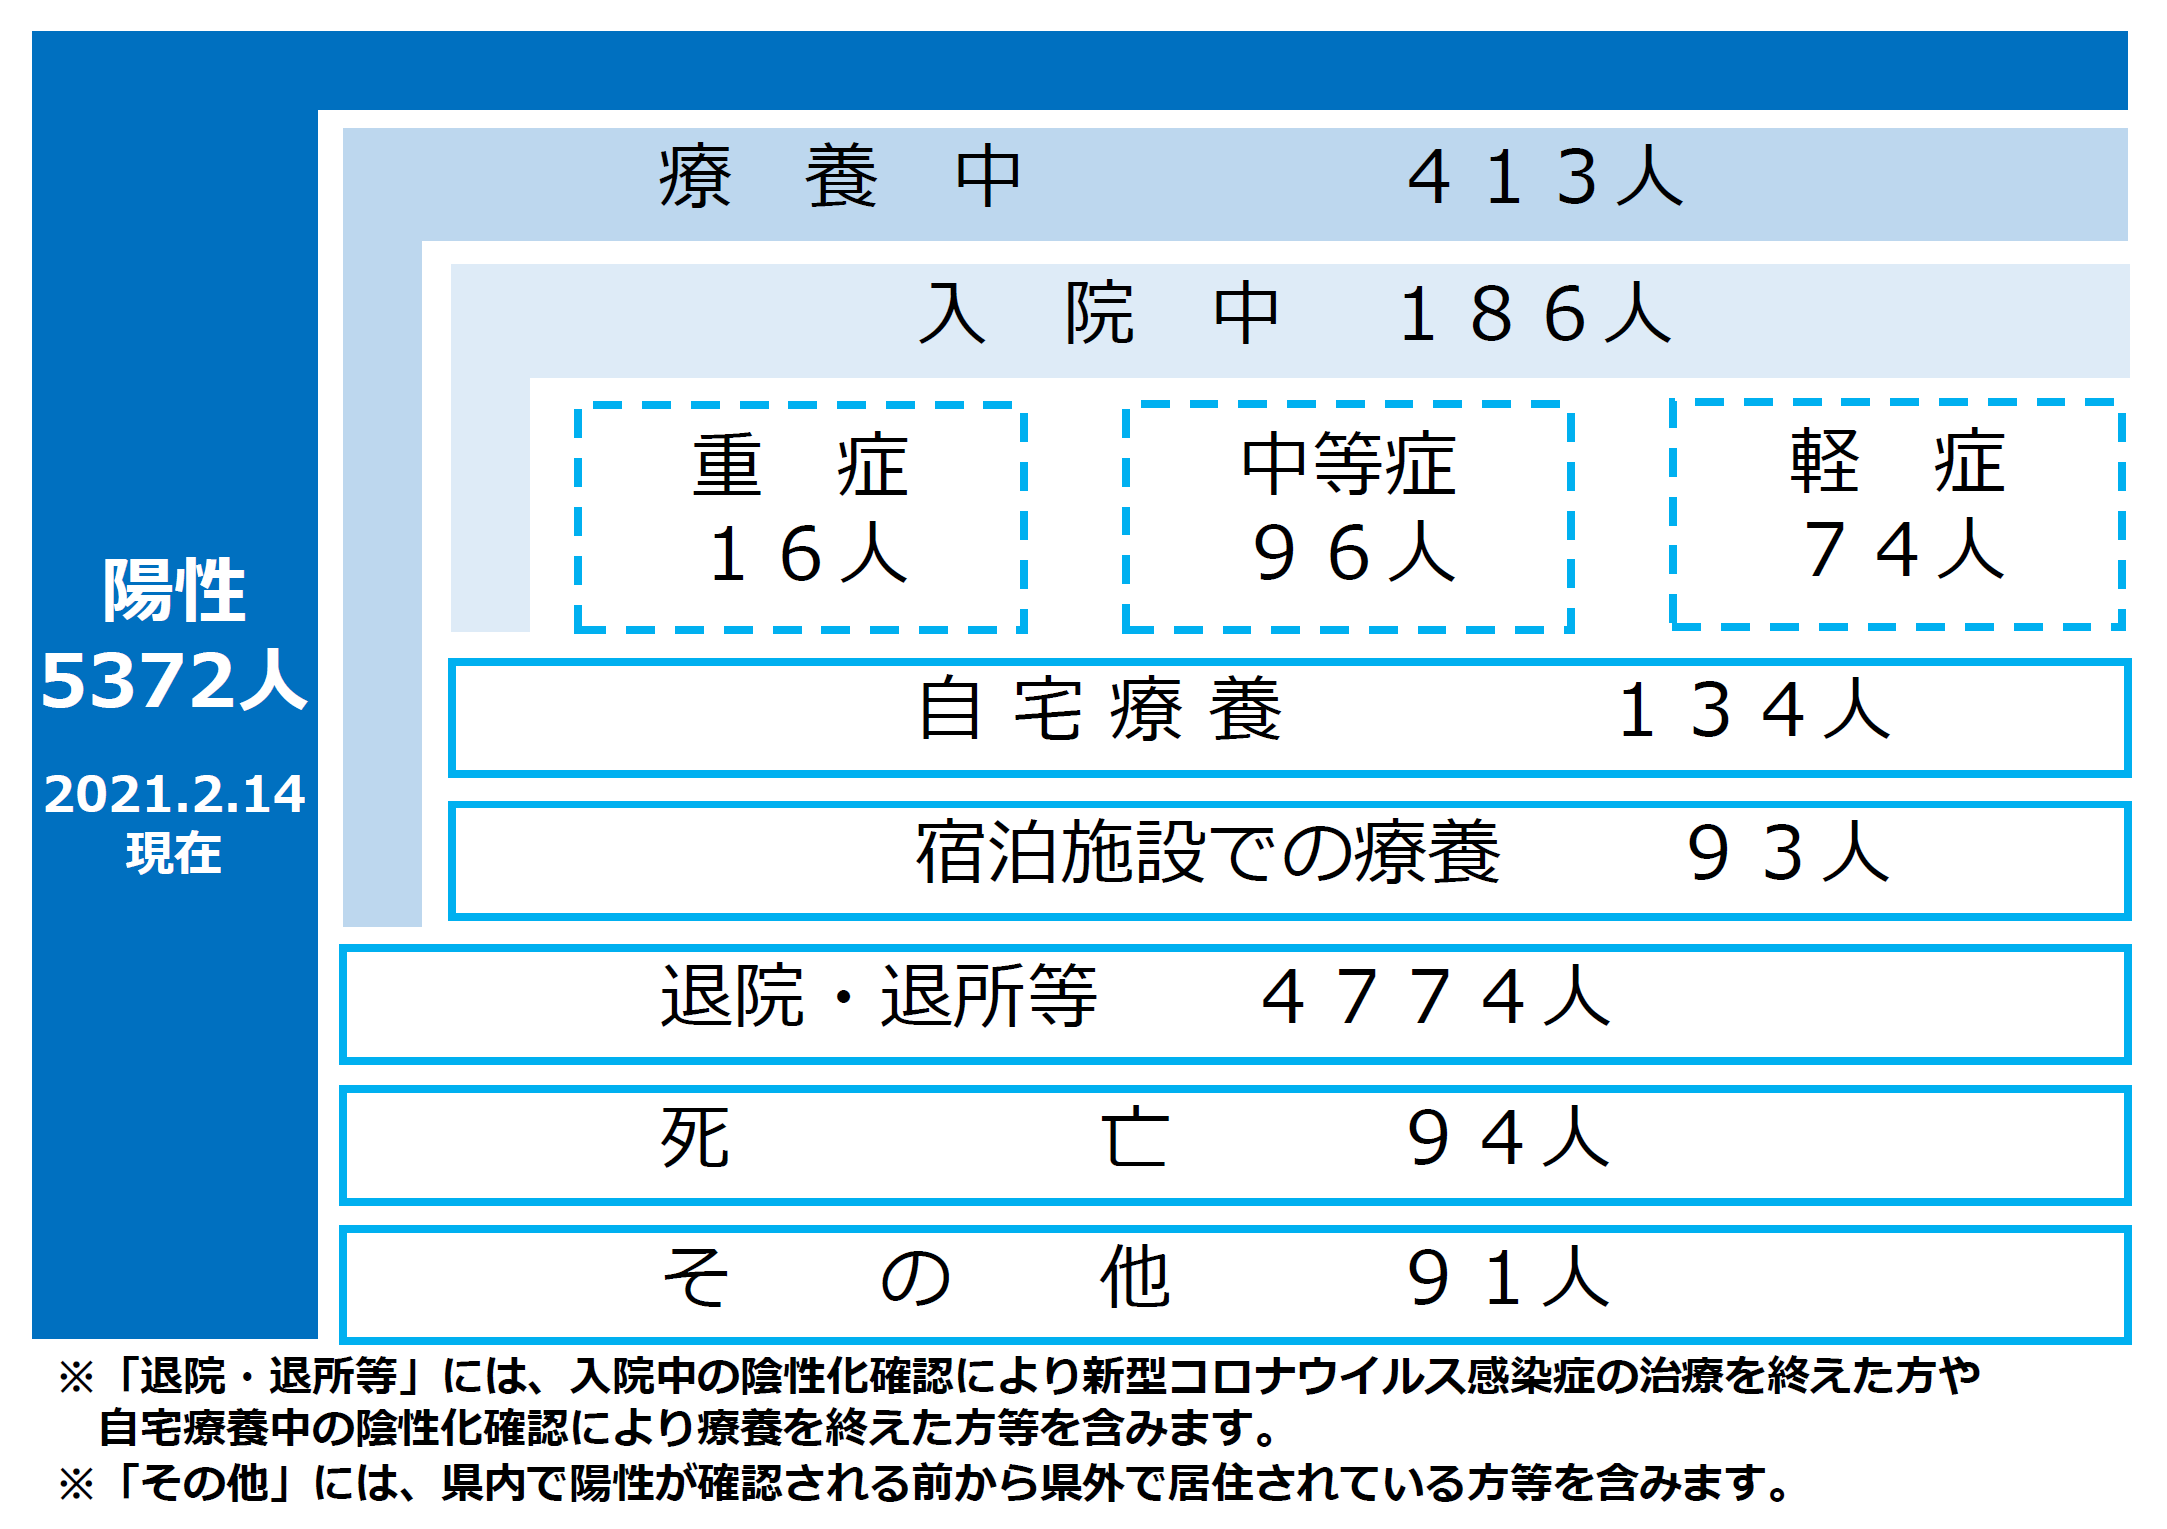

In [47]:
cv2_imshow(src)

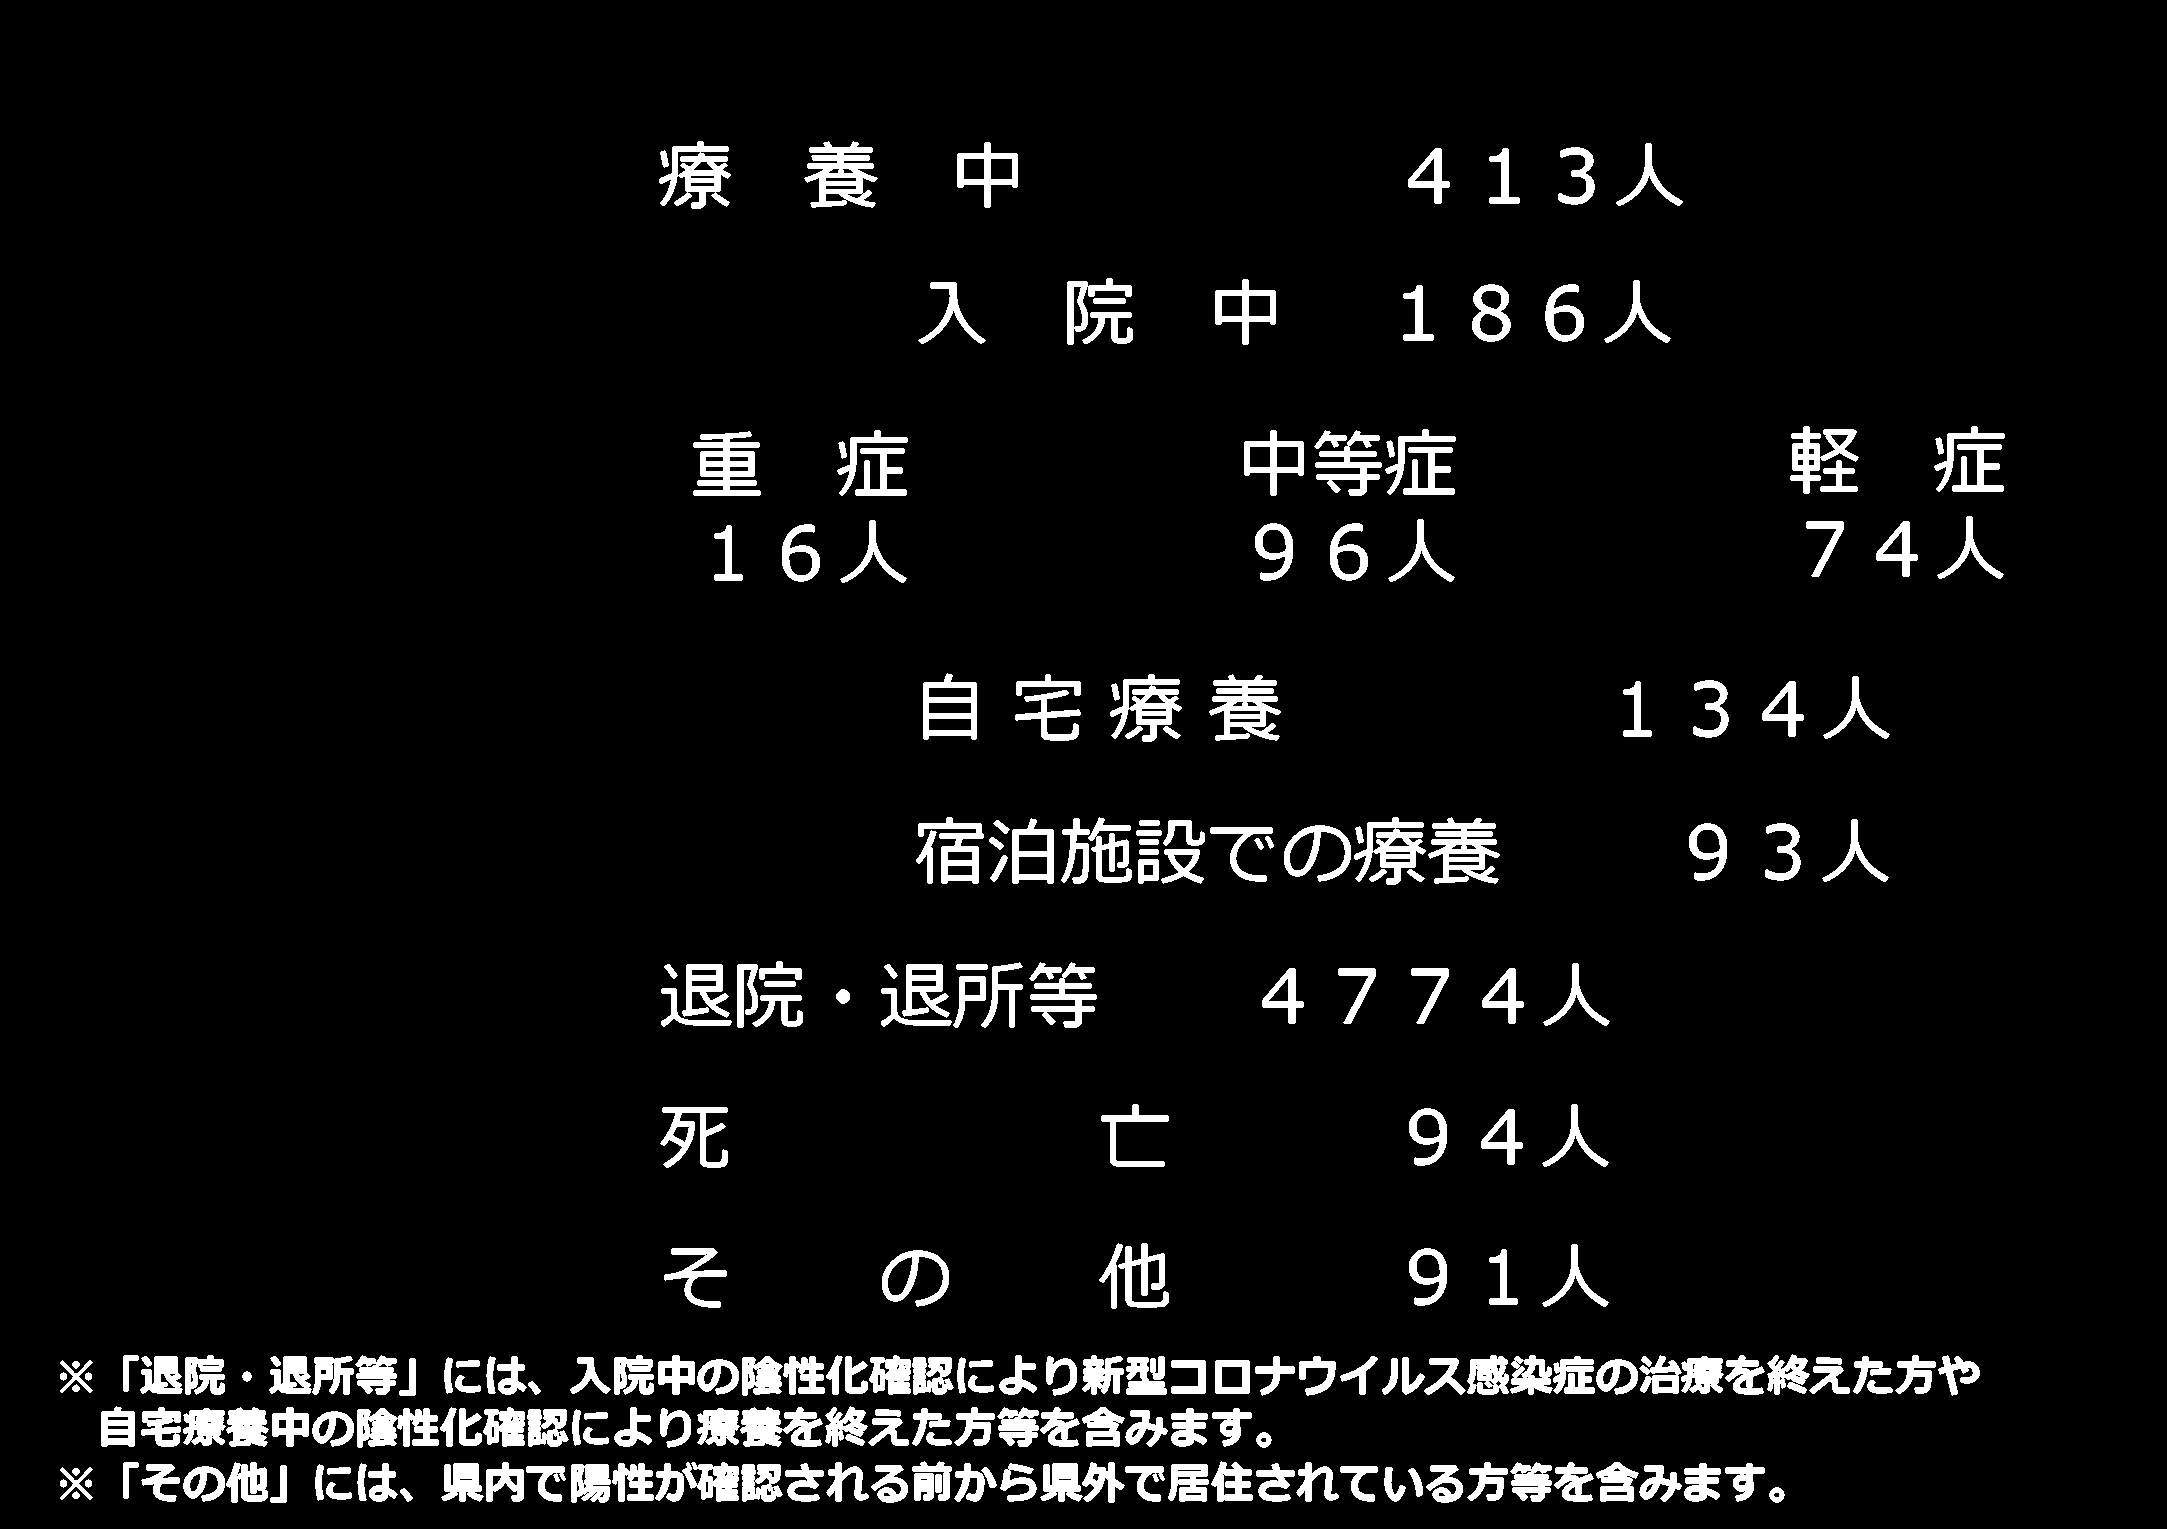

In [48]:
# 黒文字抽出
bin_img = cv2.inRange(src, (0, 0, 0), (100, 200, 200))

# 膨張
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
img = cv2.dilate(bin_img, kernel)

cv2_imshow(img)

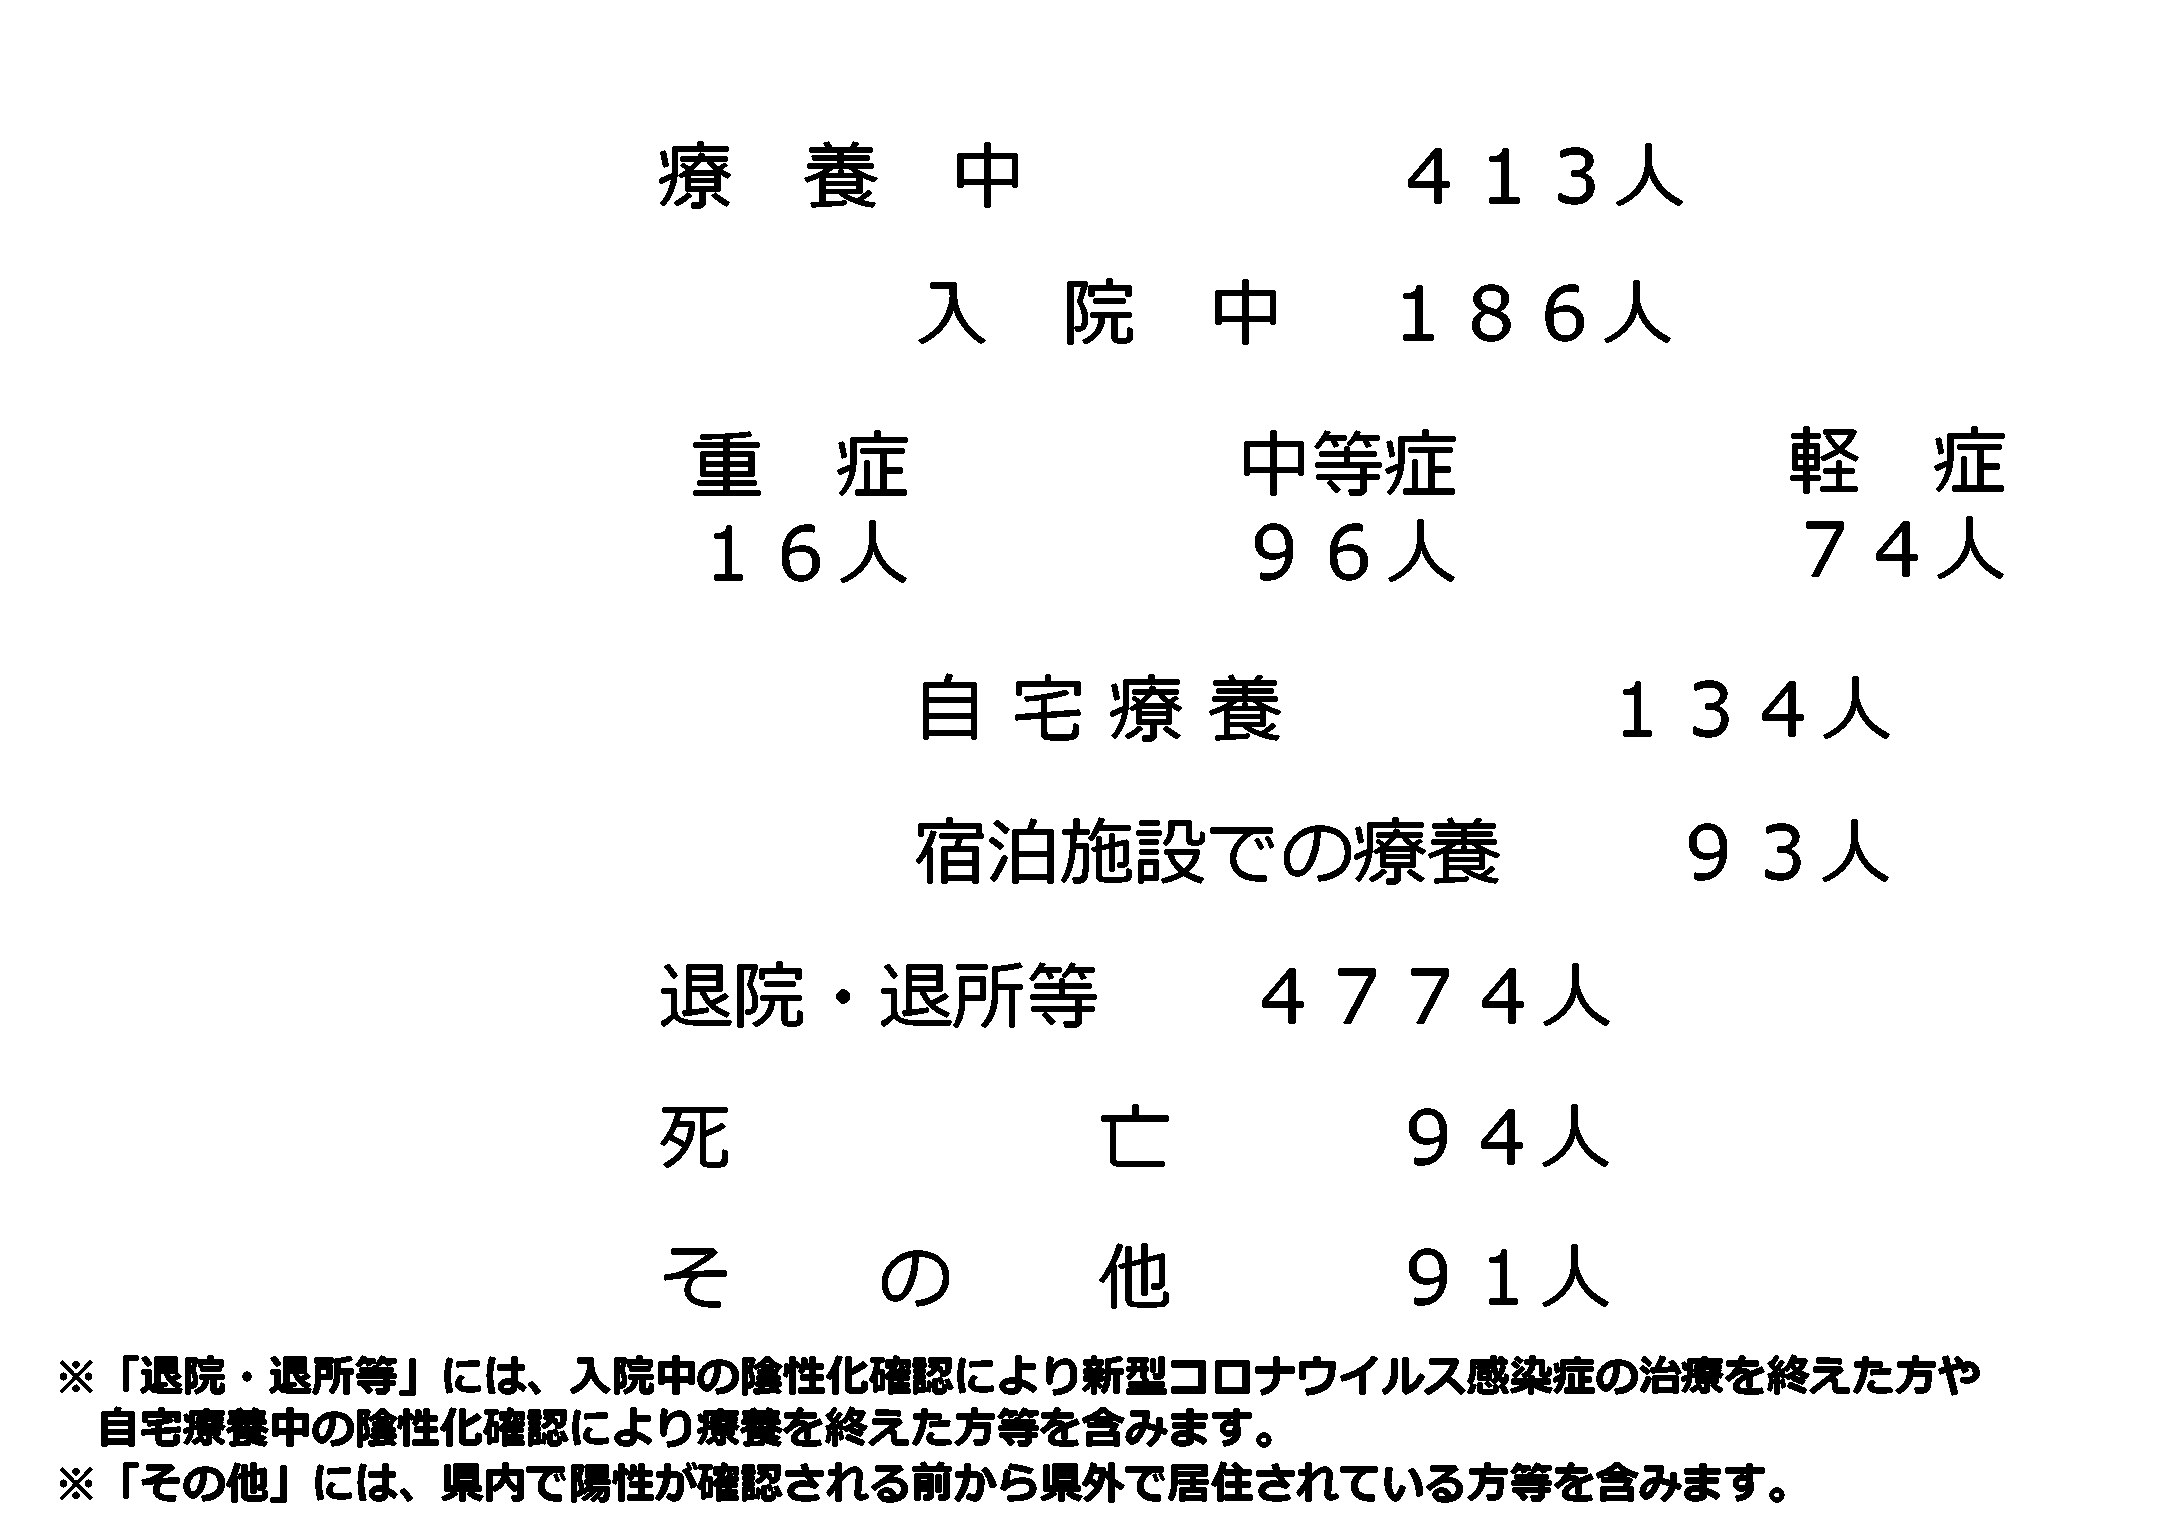

In [49]:
# 反転
dst = cv2.bitwise_not(img)
cv2_imshow(dst)

In [50]:
txt = (
    pytesseract.image_to_string(dst, lang="jpn", config="--psm 6")
    .strip()
    .replace(" ", "")
)
print(txt)

療槍中413人
入院中186人
重症中等症軽症
16人96人74人
自宅療養134人
宿泊施設での療養93人
退院・退所等4774人
死亡94人
その他91人
※[退院・退所等」には、入院中の際性化確認により新型コロナウイルス感染症の治療を終えた方や
自宅療義中の際性化確認により療養を終えた方等を含みます。
※「その他」には、県内で陽性が確認される前から県外で居住されている方等を含みます。


In [51]:
data.extend(list(map(int, re.findall("(\d+)人", txt))))

In [52]:
data

[5372, 413, 186, 16, 96, 74, 134, 93, 4774, 94, 91]

In [53]:
if data[2] != data[3] + data[4] + data[5]:
    print("入院中との合計があいません")
if data[1] != data[2] + data[6] + data[7]:
    print("療養中との合計があいません")
if data[0] != data[1] + data[8] + data[9] + data[10]:
    print("陽性との合計があいません")